In [1]:
%load_ext autoreload
%autoreload 2

# Sensitivity peak

The sensitivity has a strange peak at ca. $10^{-3}$. This notebook is investigating that to make sure that it really is just a result of numerical choices.

In [2]:
from functools import partial
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# sns.histplot = partial(sns.histplot, palette=sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1))
pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'cpu')


# import umap
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from bioreaction.simulation.manager import simulate_steady_states
from bioreaction.simulation.simfuncs.basic_de import bioreaction_sim_expanded
# from synbio_morpher.utils.misc.string_handling import string_to_tuple_list
# from synbio_morpher.utils.misc.type_handling import flatten_listlike, get_first_elements
# from synbio_morpher.utils.misc.string_handling import prettify_keys_for_label
from synbio_morpher.utils.common.testing.shared import CONFIG
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.misc.helper import vanilla_return
from synbio_morpher.utils.misc.numerical import flatten_to_matrix
from synbio_morpher.utils.misc.units import per_mol_to_per_molecule
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.modelling.physical import equilibrium_constant_reparameterisation, eqconstant_to_rates
from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import generate_analytics, compute_sensitivity, compute_peaks
from explanations.data_enhancing import enhance_data, proc_info, melt, summ

CONFIG = prepare_config(CONFIG)

## Read in data

In [3]:
# og_dir = '../data/generate_seqs_flexible/2023_04_17_205800/'

og_dir = '../data/ensemble_mutation_effect_analysis/2023_07_15_192831/generate_species_templates'

fn_og = os.path.join(og_dir, 'circuit_stats.csv')
# mut_dir = '../data/ensemble_mutation_effect_analysis/2023_05_16_174613/mutation_effect_on_interactions_signal'
# fn_mut = '../data/ensemble_mutation_effect_analysis/2023_05_16_174613/summarise_simulation/tabulated_mutation_info.csv'
mut_dir = '../data/ensemble_mutation_effect_analysis/2023_07_17_105328/mutation_effect_on_interactions_signal'
fn_mut = '../data/ensemble_mutation_effect_analysis/2023_07_17_105328/summarise_simulation/tabulated_mutation_info.csv'

data = pd.read_csv(fn_mut)

In [4]:
data, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols = proc_info(data)


/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/home/wadh6511/Kode/synbio_morpher/explanations/data_enhancing.py:77: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  mutation_log = grouped[numerical_cols].apply(


In [5]:
sensitivity_mode = data[(data['sample_name'] != 'RNA_0')]['sensitivity'].value_counts().iloc[:9].index.to_list()
sensitivity_mode

[0.00033318755,
 0.00033318793,
 0.0003331878,
 0.0003331876,
 0.00033318784,
 0.00033354628,
 0.0003331879,
 0.00033354608,
 0.00033354602]

In [6]:
sensitivity_mode_range = [sensitivity_mode[0] - 0.1*sensitivity_mode[0], sensitivity_mode[0] + 0.1*sensitivity_mode[0]]
sensitivity_mode_range

[0.000299868795, 0.00036650630500000003]

## Load circuits

In [7]:
data['circuit_id'] = list(map(lambda x: '-'.join(x), data[['circuit_name', 'mutation_name']].to_numpy()))

sens_data = data[data['sensitivity'].isin(sensitivity_mode)]
choice_data = data[data['circuit_id'].isin(sens_data['circuit_id'])]

Text(0.5, 1.0, 'Sensitivity for all species when one is at mode')

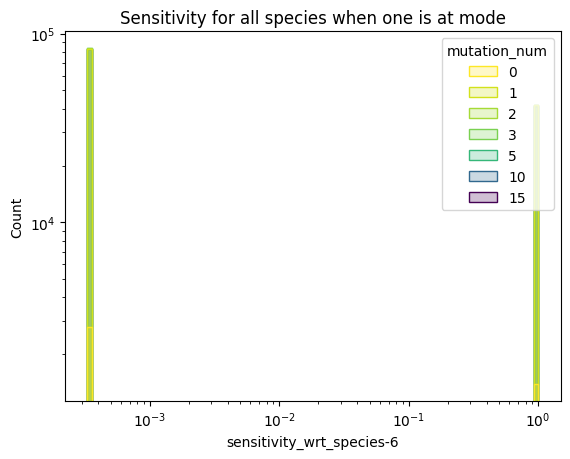

In [8]:
sns.histplot(choice_data, x='sensitivity', hue='mutation_num', element='step', bins=100, log_scale=[True, True], palette='viridis_r')
plt.title('Sensitivity for all species when one is at mode')

In [9]:
def load_circuit(circ_row, config):
    
    circ_path = os.path.join(og_dir, 'circuits', circ_row['name'] + '.fasta')
    interactions = {'binding_rates_association': config['molecular_params']['association_binding_rate' + '_per_molecule'],
                    'binding_rates_dissociation': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_rates_dissociation')]),
                    'eqconstants': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'eqconstants')]),
                    'energies': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'energies')]),
                    'binding_sites': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_sites')])}
    circuit = construct_circuit_from_cfg({
        'data_path': circ_path,
        'interactions': interactions
    }, config)
    circuit.subname = circ_row['mutation_name']
    return circuit
    

nm = 3
circuits = []
num_circuits = 5
for i in range(num_circuits):
    ref_c = choice_data[(choice_data['sample_name'] == 'RNA_1') & (choice_data['mutation_name'] == 'ref_circuit')].iloc[i]
    mut_c = choice_data[(choice_data['sample_name'] == 'RNA_1') & (choice_data['circuit_name'] == ref_c['circuit_name']) & (choice_data['mutation_name'] != 'ref_circuit')].iloc[:nm]
    circuits.append(load_circuit(circ_row=ref_c, config=CONFIG))
    for mi in range(len(mut_c)):
        circuits.append(load_circuit(circ_row=mut_c.iloc[mi], config=CONFIG))
        

forward_rates = circuits[0].qreactions.reactions.forward_rates
reverse_rates = np.asarray(
    [c.qreactions.reactions.reverse_rates for c in circuits])


t0 = 0 
t1 = 500
dt = 0.001
tmax = 5000
threshold_steady_states = 0.05

signal_onehot = np.zeros_like(circuits[0].signal.reactions_onehot) if circuits[0].use_prod_and_deg else np.zeros_like(circuits[0].signal.onehot)
sim_func = jax.jit(jax.vmap(partial(bioreaction_sim_dfx_expanded,
                            t0=t0, t1=t1, dt0=dt,
                            signal=vanilla_return, signal_onehot=signal_onehot,
                            inputs=circuits[0].qreactions.reactions.inputs,
                            outputs=circuits[0].qreactions.reactions.outputs,
                            forward_rates=forward_rates,
                            solver=dfx.Tsit5(),
                            saveat=dfx.SaveAt(
                                ts=np.linspace(t0, t1, int(np.min([200, t1-t0]))))
                            )))


xla_bridge.py:backends():450: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Host CUDA Interpreter INFO
xla_bridge.py:backends():450: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client' INFO
xla_bridge.py:backends():450: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this. INFO


In [10]:

starting_states = np.asarray(
    [c.qreactions.quantities for c in circuits])
b_copynumbers, tss = simulate_steady_states(
    y0=starting_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=t1,
    threshold=threshold_steady_states, reverse_rates=reverse_rates)

b_copynumbers = np.swapaxes(b_copynumbers, 1, 2)


Done:  0:01:20.148271


In [11]:
signal_species_idx = 6

b_steady_states = b_copynumbers[:, :, -1]
b_steady_states[:, signal_species_idx] += 2 * b_copynumbers[:, signal_species_idx, 0]

b_new_copynumbers, tyy = simulate_steady_states(
    y0=b_steady_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=tss[-1],
    threshold=threshold_steady_states,
    reverse_rates=reverse_rates)

b_new_copynumbers = np.swapaxes(b_new_copynumbers, 1, 2)

Done:  0:01:18.235852


Text(0.5, 0.98, 'Circuit traces: reference and mutations')

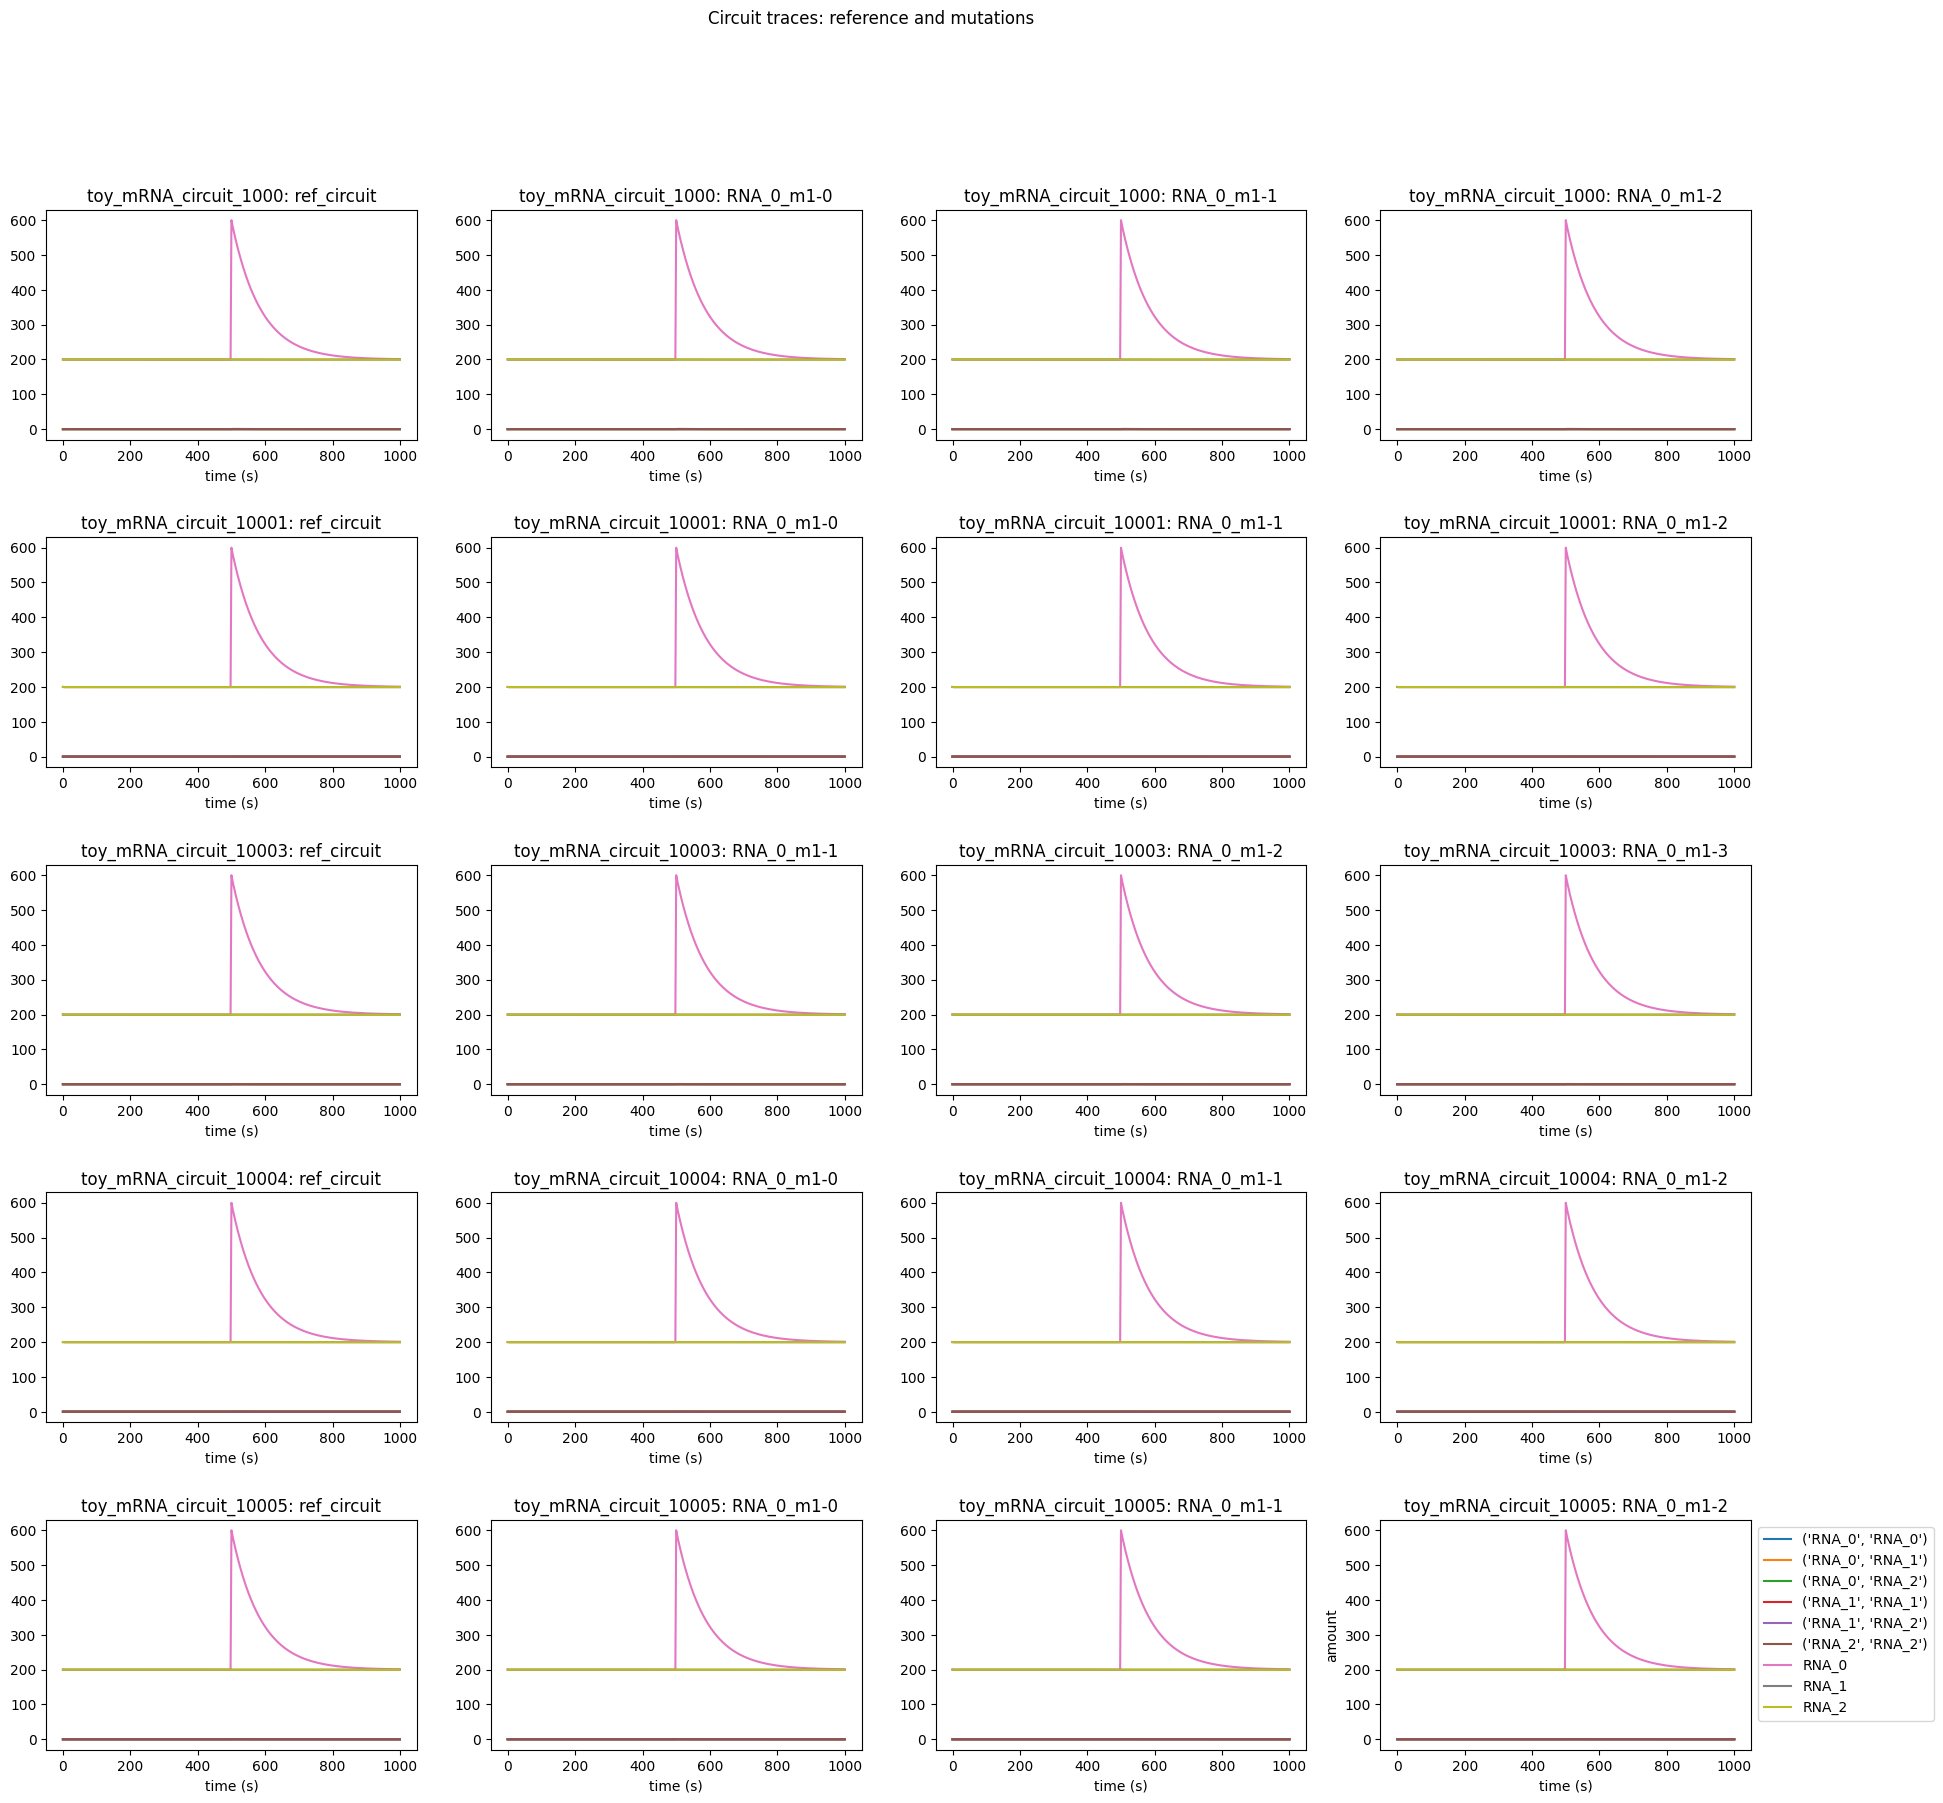

In [12]:
fig = plt.figure(figsize=(22, 20))
fig.subplots_adjust(hspace=0.425)
for i in range(len(circuits)):
    ax = plt.subplot(num_circuits,nm+1,i+1)
    plt.plot(np.concatenate([tss, tyy + tss[-1]]), np.concatenate([b_copynumbers[i].T, b_new_copynumbers[i].T]))
    plt.title(f'{circuits[i].name}: {circuits[i].subname}')
    plt.xlabel('time (s)')
plt.legend([s.name for s in circuits[0].model.species], loc='upper right')
plt.ylabel('amount')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))

plt.suptitle('Circuit traces: reference and mutations')


## Analytics from trace

In [13]:

def append_nest_dicts(l: list, i1: int, d: dict) -> list:
    for i in range(i1):
        b_analytics_k = {}
        for k, v in d.items():
            b_analytics_k[k] = v[i]
        l.append(b_analytics_k)
    return l
b_analytics_l = []
        
ref_idxs = [i for i, x in enumerate([c.subname for c in circuits]) if x == "ref_circuit"]
for ref_idx, ref_idx2 in zip(ref_idxs, ref_idxs[1:] + [len(circuits)]):
    ref_circuit = circuits[ref_idx]
    analytics_func = jax.vmap(partial(
        generate_analytics, time=tyy, labels=[
            s.name for s in ref_circuit.model.species],
        signal_onehot=ref_circuit.signal.onehot, signal_time=1))
    b_analytics = analytics_func(
        data=b_new_copynumbers[ref_idx:ref_idx2])
    
    b_analytics_l = append_nest_dicts(
        b_analytics_l, ref_idx2 - ref_idx, b_analytics)

In [14]:
b_analytics = np.array([b['sensitivity'] for b in b_analytics_l])
b_analytics.shape


(20, 9)

In [15]:
# b_analytics = b_analytics_l[0]['sensitivity']
# for b in b_analytics_l[1:]:
#     b_analytics = np.concatenate([b_analytics, b['sensitivity']], axis=1)

In [16]:
np.sum((b_analytics > sensitivity_mode[0] - 0.01) | (b_analytics < sensitivity_mode[0] + 0.01))

180

In [17]:
data[data['sensitivity'].isin(sensitivity_mode)]

,circuit_name,mutation_name,mutation_num,mutation_type,mutation_positions,path_to_template_circuit,index,name,interacting,self_interacting,...,binding_sites_groups_0-0_logm,binding_sites_groups_0-1_logm,binding_sites_groups_0-2_logm,binding_sites_groups_1-0_logm,binding_sites_groups_1-1_logm,binding_sites_groups_1-2_logm,binding_sites_groups_2-0_logm,binding_sites_groups_2-1_logm,binding_sites_groups_2-2_logm,circuit_id
184,toy_mRNA_circuit_0,RNA_1_m1-0,1,[4],[5],data/ensemble_mutation_effect_analysis/2023_07...,60.0,toy_mRNA_circuit_0,[],[],...,0,0,0,0,0,0,0,0,0,toy_mRNA_circuit_0-RNA_1_m1-0
185,toy_mRNA_circuit_0,RNA_1_m1-0,1,[4],[5],data/ensemble_mutation_effect_analysis/2023_07...,60.0,toy_mRNA_circuit_0,[],[],...,0,0,0,0,0,0,0,0,0,toy_mRNA_circuit_0-RNA_1_m1-0
199,toy_mRNA_circuit_0,RNA_1_m1-5,1,[7],[4],data/ensemble_mutation_effect_analysis/2023_07...,65.0,toy_mRNA_circuit_0,[],[],...,0,0,0,0,0,0,0,0,0,toy_mRNA_circuit_0-RNA_1_m1-5
200,toy_mRNA_circuit_0,RNA_1_m1-5,1,[7],[4],data/ensemble_mutation_effect_analysis/2023_07...,65.0,toy_mRNA_circuit_0,[],[],...,0,0,0,0,0,0,0,0,0,toy_mRNA_circuit_0-RNA_1_m1-5
208,toy_mRNA_circuit_0,RNA_1_m1-8,1,[3],[5],data/ensemble_mutation_effect_analysis/2023_07...,68.0,toy_mRNA_circuit_0,[],[],...,0,0,0,0,0,0,0,0,0,toy_mRNA_circuit_0-RNA_1_m1-8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628993,toy_mRNA_circuit_12699,RNA_2_m5-7,5,"[7, 4, 2, 4, 0]","[17, 5, 18, 7, 4]",data/ensemble_mutation_effect_analysis/2023_07...,157.0,toy_mRNA_circuit_12699,[],[],...,0,0,0,0,0,0,0,0,0,toy_mRNA_circuit_12699-RNA_2_m5-7
1628995,toy_mRNA_circuit_12699,RNA_2_m5-8,5,"[4, 0, 5, 5, 6]","[8, 4, 13, 2, 6]",data/ensemble_mutation_effect_analysis/2023_07...,158.0,toy_mRNA_circuit_12699,[],[],...,0,0,0,0,0,0,0,0,0,toy_mRNA_circuit_12699-RNA_2_m5-8
1628996,toy_mRNA_circuit_12699,RNA_2_m5-8,5,"[4, 0, 5, 5, 6]","[8, 4, 13, 2, 6]",data/ensemble_mutation_effect_analysis/2023_07...,158.0,toy_mRNA_circuit_12699,[],[],...,0,0,0,0,0,0,0,0,0,toy_mRNA_circuit_12699-RNA_2_m5-8
1628998,toy_mRNA_circuit_12699,RNA_2_m5-9,5,"[6, 3, 6, 5, 0]","[0, 7, 3, 2, 18]",data/ensemble_mutation_effect_analysis/2023_07...,159.0,toy_mRNA_circuit_12699,[],[],...,0,0,0,0,0,0,0,0,0,toy_mRNA_circuit_12699-RNA_2_m5-9


### Steady states

Text(0.5, 0.98, 'Initial and steady states distributions')

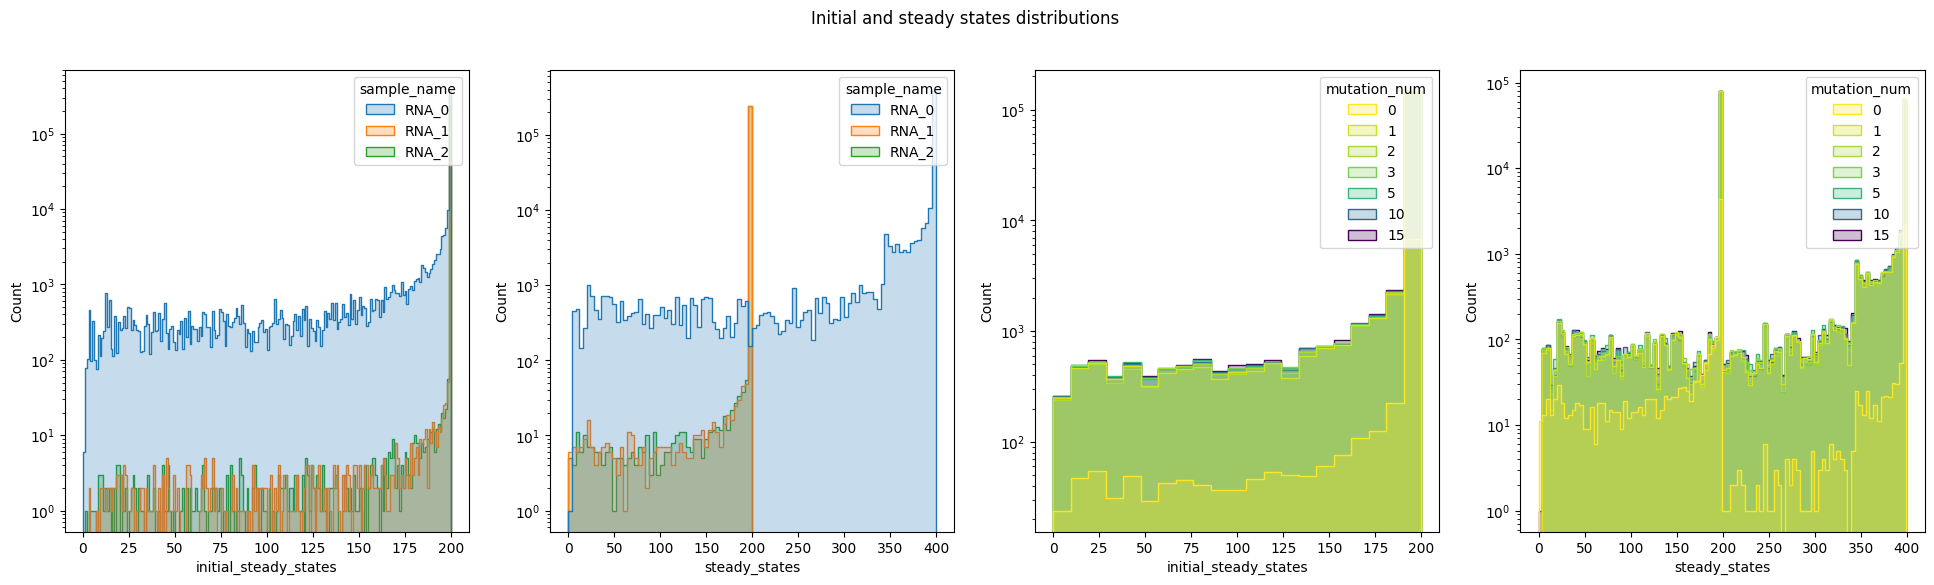

In [17]:
plt.figure(figsize=(24,6))
ax = plt.subplot(1,4,1)
sns.histplot(choice_data, x='initial_steady_states', hue='sample_name', element='step', bins=200, log_scale=[False, True])

ax = plt.subplot(1,4,2)
sns.histplot(choice_data, x='steady_states', hue='sample_name', element='step', log_scale=[False, True])

ax = plt.subplot(1,4,3)
sns.histplot(choice_data, x='initial_steady_states', hue='mutation_num', element='step', log_scale=[False, True], palette='viridis_r')

ax = plt.subplot(1,4,4)
sns.histplot(choice_data, x='steady_states', hue='mutation_num', element='step', log_scale=[False, True], legend=True, palette='viridis_r')

plt.suptitle('Initial and steady states distributions')


### Fold change

Text(0.5, 0.98, 'Sensitivity vs. Fold change\nrelating to mode of sensitivity (no RNA_0)')

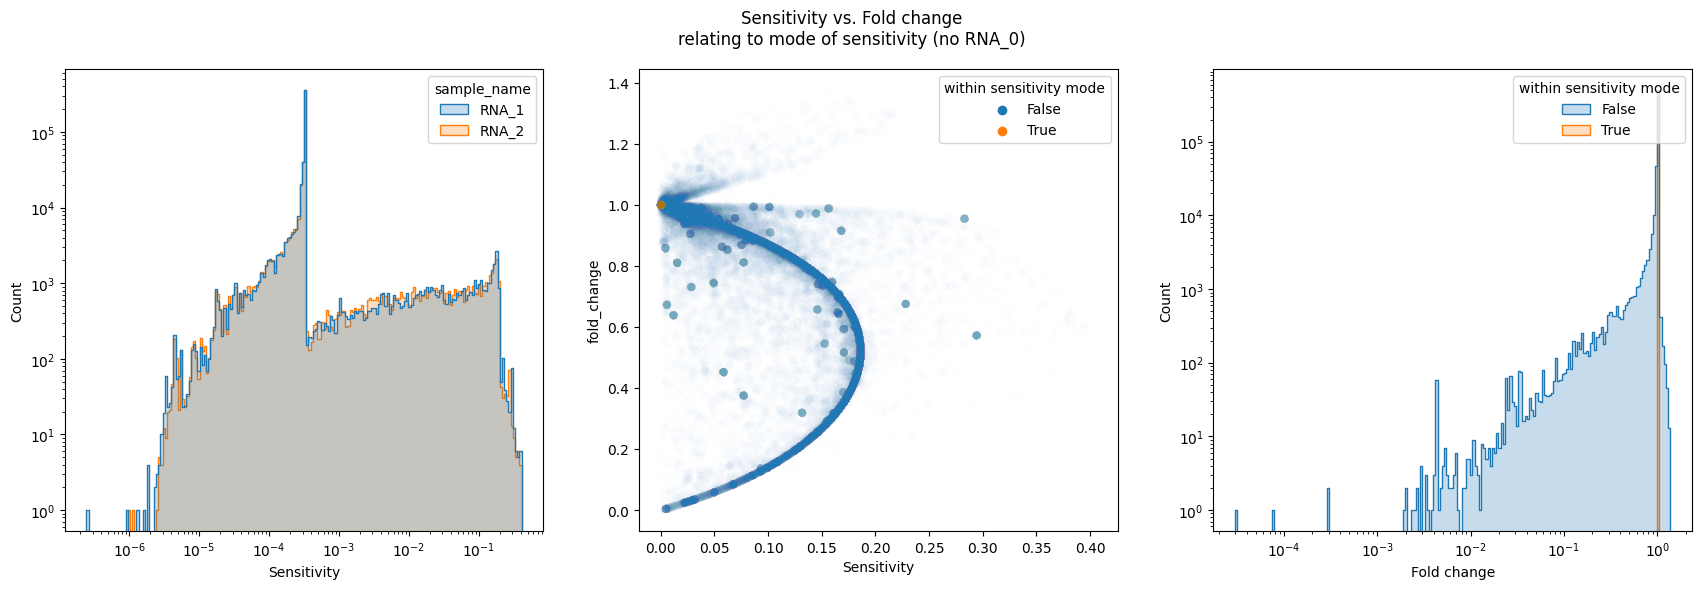

In [71]:
plt.figure(figsize=(21,6))
ax = plt.subplot(1,3,1)
sns.histplot(data[(data['sensitivity'] > 0) & (data['sample_name'] != 'RNA_0')], x='sensitivity', 
             hue='sample_name', element='step', bins=200, log_scale=[True, True])
plt.xlabel('Sensitivity')

ax = plt.subplot(1,3,2)
sns.scatterplot(data[(data['sensitivity'] > 0) & (data['sample_name'] != 'RNA_0')], x='sensitivity', 
                y='fold_change', hue=data[(data['sensitivity'] > 0) & (data['sample_name'] != 'RNA_0')]['sensitivity'].isin(sensitivity_mode),
                alpha=0.01)
ax.get_legend().set_title('within sensitivity mode')
plt.xlabel('Sensitivity')

ax = plt.subplot(1,3,3)
sns.histplot(data[(data['sensitivity'] > 0) & (data['sample_name'] != 'RNA_0')], x='fold_change', 
             hue=data['sensitivity'].isin(sensitivity_mode), element='step', bins=200, log_scale=[True, True])
ax.get_legend().set_title('within sensitivity mode')
plt.xlabel('Fold change')

plt.suptitle('Sensitivity vs. Fold change\nrelating to mode of sensitivity (no RNA_0)')


Text(0.5, 1.0, 'Sensitivity vs. ratio of final / initial states (no RNA_0)')

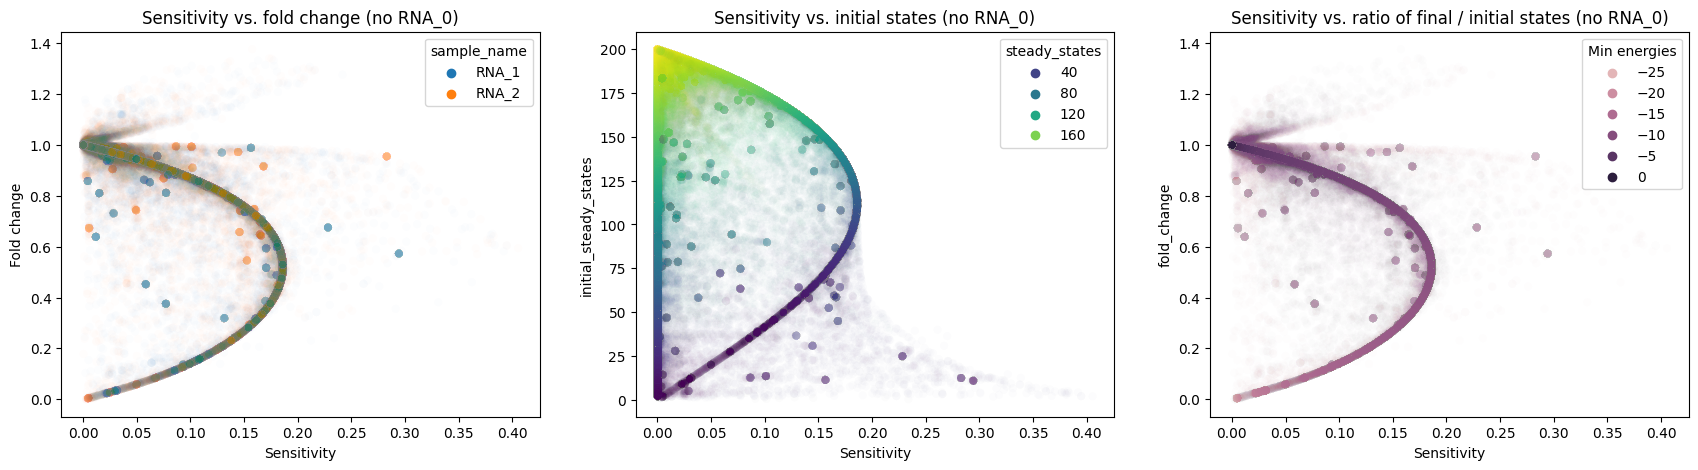

In [49]:
fig = plt.figure(figsize=(3*7, 5))
ax = plt.subplot(1, 3, 1)
sns.scatterplot(data[(data['sample_name'] != 'RNA_0')], x='sensitivity',
                y='fold_change', hue='sample_name', alpha=0.01)
# ax.get_legend().set_title('within sensitivity mode')
plt.xlabel('Sensitivity')
plt.ylabel('Fold change')
plt.title('Sensitivity vs. fold change (no RNA_0)')

ax = plt.subplot(1,3,2)
sns.scatterplot(data[(data['sample_name'] != 'RNA_0')], x='sensitivity',
                y='initial_steady_states', hue='steady_states', alpha=0.01, palette='viridis')
# ax.get_legend().set_title('within sensitivity mode')
plt.xlabel('Sensitivity')
plt.title('Sensitivity vs. initial states (no RNA_0)')

ax = plt.subplot(1,3,3)
sns.scatterplot(data[(data['sample_name'] != 'RNA_0')], x='sensitivity',
                y='fold_change', hue=data[(data['sample_name'] != 'RNA_0')][get_true_interaction_cols(data, 'energies', remove_symmetrical=True)].min(axis=1),
                alpha=0.01)
ax.get_legend().set_title('Min energies')
plt.xlabel('Sensitivity')
plt.title('Sensitivity vs. ratio of final / initial states (no RNA_0)')

Text(0.5, 0.98, 'Initial and steady states relating to the mode of sensitivity')

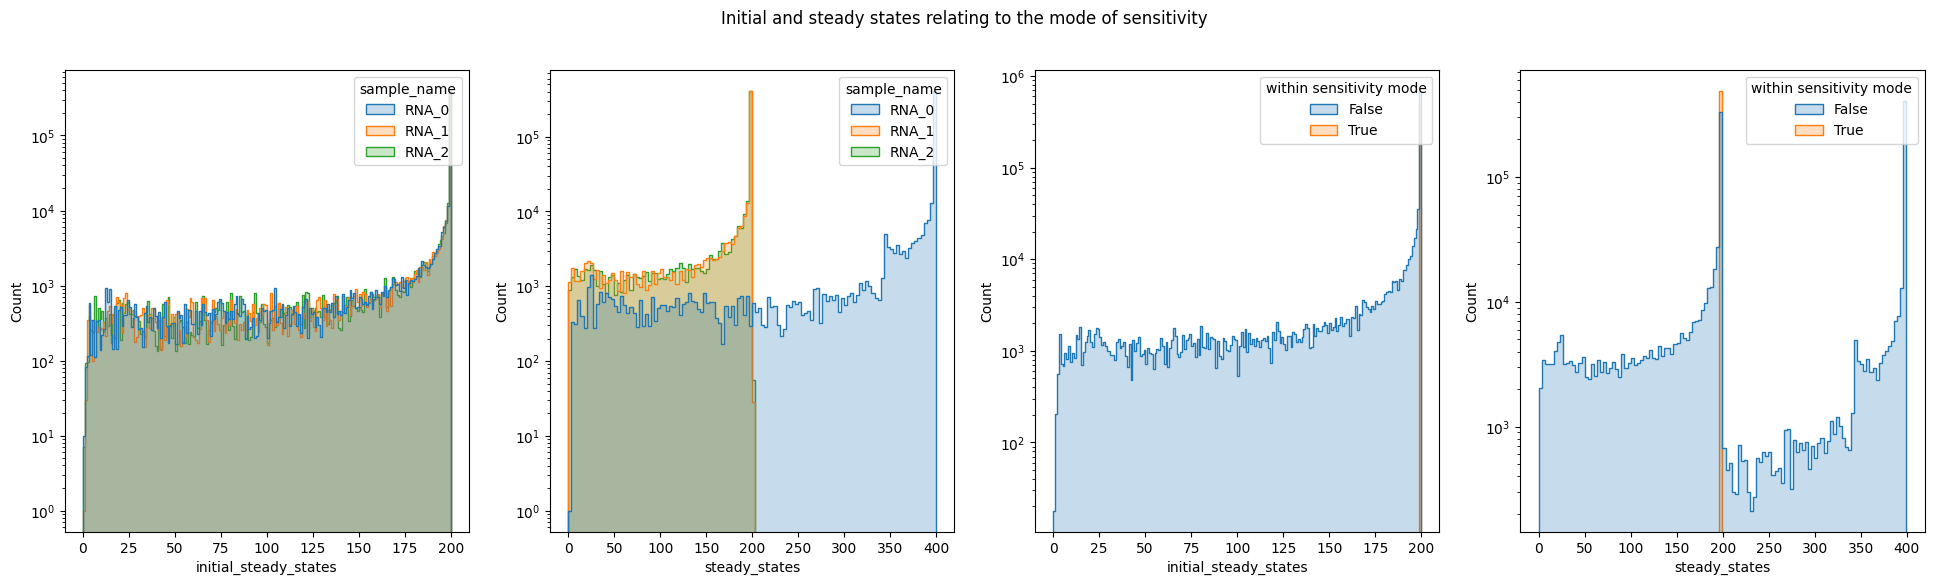

In [72]:
plt.figure(figsize=(24,6))
ax = plt.subplot(1,4,1)
sns.histplot(data, x='initial_steady_states', hue='sample_name', element='step', bins=200, log_scale=[False, True])

ax = plt.subplot(1,4,2)
sns.histplot(data, x='steady_states', hue='sample_name', element='step', log_scale=[False, True])

ax = plt.subplot(1,4,3)
sns.histplot(x=data['initial_steady_states'], hue=data['sensitivity'].isin(sensitivity_mode), element='step', bins=200, log_scale=[False, True])
ax.get_legend().set_title('within sensitivity mode')

ax = plt.subplot(1,4,4)
sns.histplot(x=data['steady_states'], hue=data['sensitivity'].isin(sensitivity_mode), element='step', log_scale=[False, True], legend=True)
ax.get_legend().set_title('within sensitivity mode')

plt.suptitle('Initial and steady states relating to the mode of sensitivity')


Text(0.5, 1.0, 'Fold change relating to sensitivity mode')

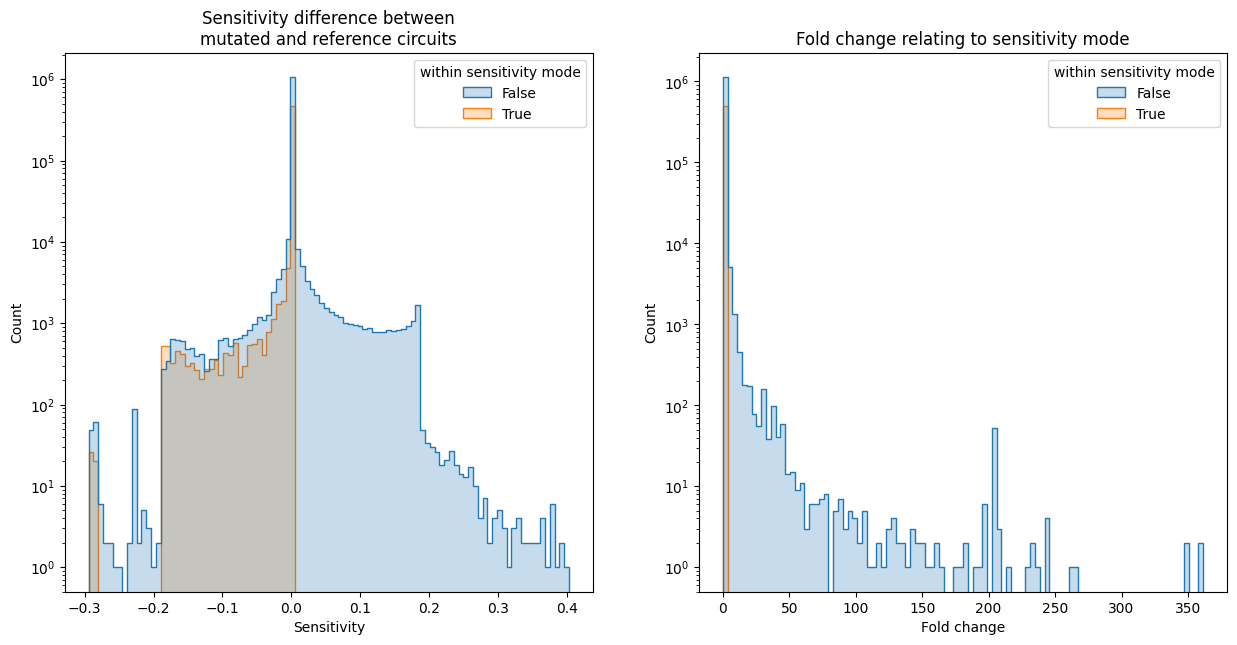

In [75]:
plt.figure(figsize=(15,7))
ax = plt.subplot(1,2,1)
sns.histplot(x=data['sensitivity_diff_to_base_circuit'], hue=data['sensitivity'].isin(sensitivity_mode), element='step', bins=100, log_scale=[False, True])
ax.get_legend().set_title('within sensitivity mode')
plt.xlabel('Sensitivity')
plt.title('Sensitivity difference between\nmutated and reference circuits')

ax = plt.subplot(1,2,2)
sns.histplot(x=data['fold_change'], hue=data['sensitivity'].isin(sensitivity_mode), element='step', bins=100, log_scale=[False, True])
ax.get_legend().set_title('within sensitivity mode')
plt.xlabel('Fold change')
plt.title('Fold change relating to sensitivity mode')


In [21]:
o2 = choice_data[choice_data['sample_name'] == 'RNA_1']['steady_states'] #.reset_index()
o1 = choice_data[choice_data['sample_name'] == 'RNA_1']['initial_steady_states'] #.reset_index()
i2 = choice_data[choice_data['sample_name'] == 'RNA_0']['steady_states'] #.reset_index()
i1 = choice_data[choice_data['sample_name'] == 'RNA_0']['initial_steady_states'] #.reset_index()

sens = ((o2 - o1) / o1).reset_index() / ((i2 - i1) / i1).reset_index()
sens

,index,0
0,inf,-0.040728
1,61.333333,-0.000328
2,33.166667,-0.000306
3,23.111111,-0.000316
4,17.583333,-0.000332
...,...,...
487428,NaN,NaN
487429,NaN,NaN
487430,NaN,NaN
487431,NaN,NaN


### Energies

In [18]:
energy_cols = get_true_interaction_cols(
    data, 'energies', remove_symmetrical=True, num_species=len(data['sample_name'].unique()))

Text(0.5, 0.98, 'Energies mean vs. sensitivity')

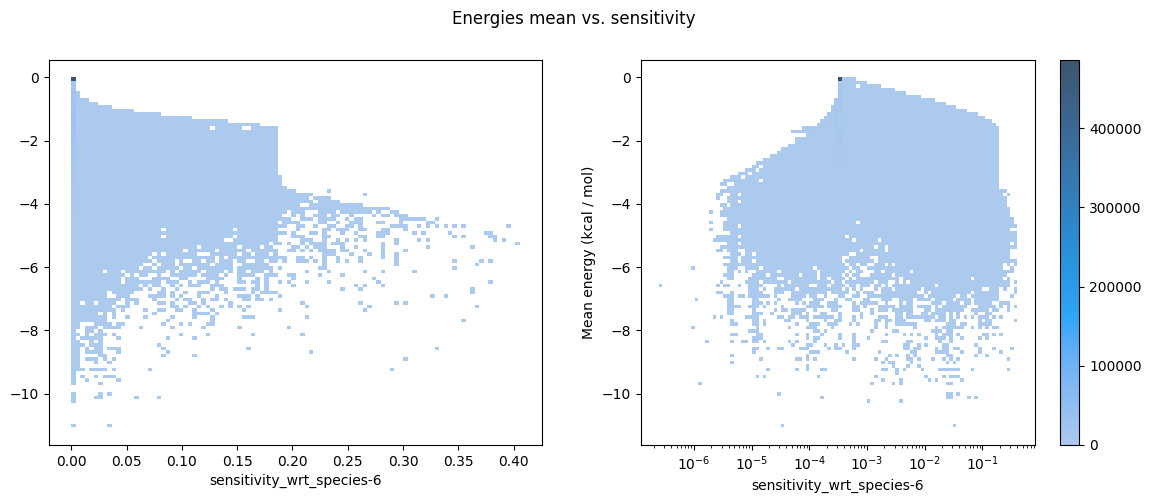

In [129]:
fig = plt.figure(figsize=(2*7,5))
ax = plt.subplot(1,2,1)
sns.histplot(data[data['sample_name'] != 'RNA_0'], x='sensitivity', y=data[energy_cols].mean(axis=1), 
             element='step', bins=100, cbar=False, log_scale=[False, False])
ax = plt.subplot(1,2,2)
plt.ylabel('Mean energy (kcal / mol)')
sns.histplot(data[data['sample_name'] != 'RNA_0'], x='sensitivity', y=data[energy_cols].mean(axis=1), 
             element='step', bins=100, cbar=True, log_scale=[True, False])
plt.suptitle('Energies mean vs. sensitivity')

Text(0, 0.5, 'Energies mean')

/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


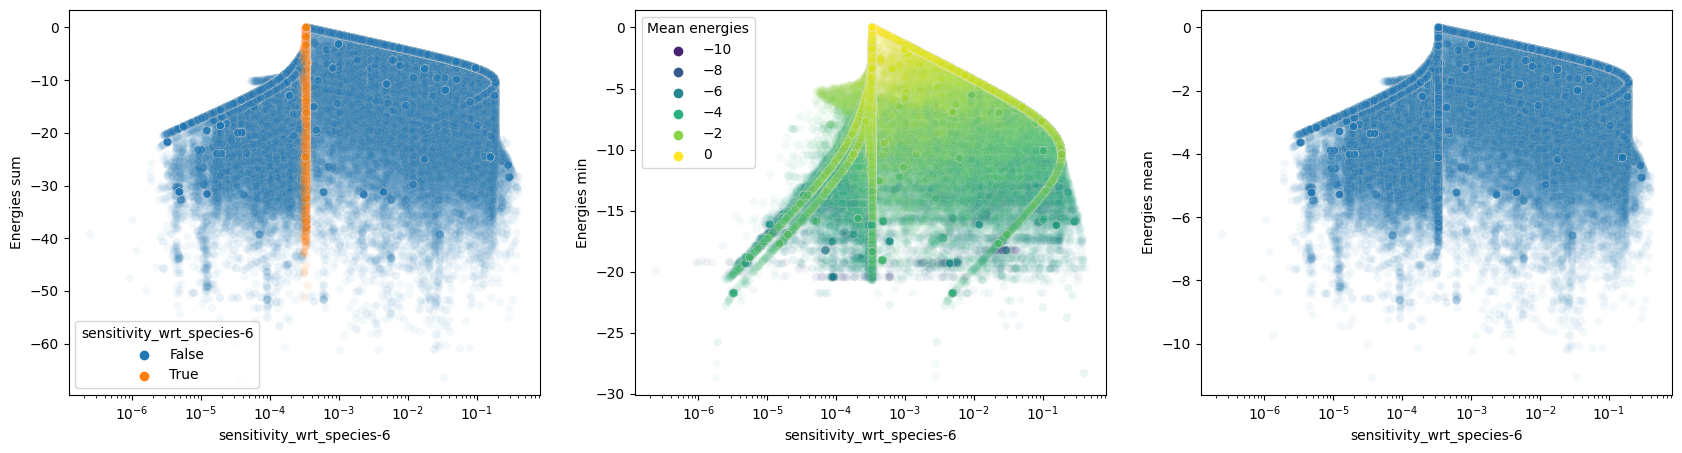

In [83]:
filt = data['sample_name'] != 'RNA_0'

plt.figure(figsize=(4*7, 5))
ax = plt.subplot(1, 4, 1)
sns.scatterplot(x=data[filt]['sensitivity'], y=data[filt][energy_cols].sum(axis=1), alpha=0.05,
    hue=(data[filt]['sensitivity'] > sensitivity_mode_range[0]) & (data[filt]['sensitivity'] < sensitivity_mode_range[1]))
ax.get_legend().set_title('Within sensitivity mode')
plt.xscale('log')
plt.ylabel('Energies sum')
ax = plt.subplot(1, 4, 2)
sns.scatterplot(x=data[filt]['sensitivity'], y=data[filt][energy_cols].min(axis=1), alpha=0.05,
    hue=data[filt][get_true_interaction_cols(
        data, 'energies', remove_symmetrical=True, num_species=len(data['sample_name'].unique()))].mean(axis=1), palette='viridis')
ax.get_legend().set_title('Mean energies')
plt.xscale('log')
plt.ylabel('Energies min')
ax = plt.subplot(1, 4, 3)
sns.scatterplot(x=data[filt]['sensitivity'], y=data[filt][energy_cols].mean(axis=1), alpha=0.05)
plt.xscale('log')
plt.ylabel('Energies mean')

Text(0.5, 0.98, 'Energies in sensitivity mode circuits')

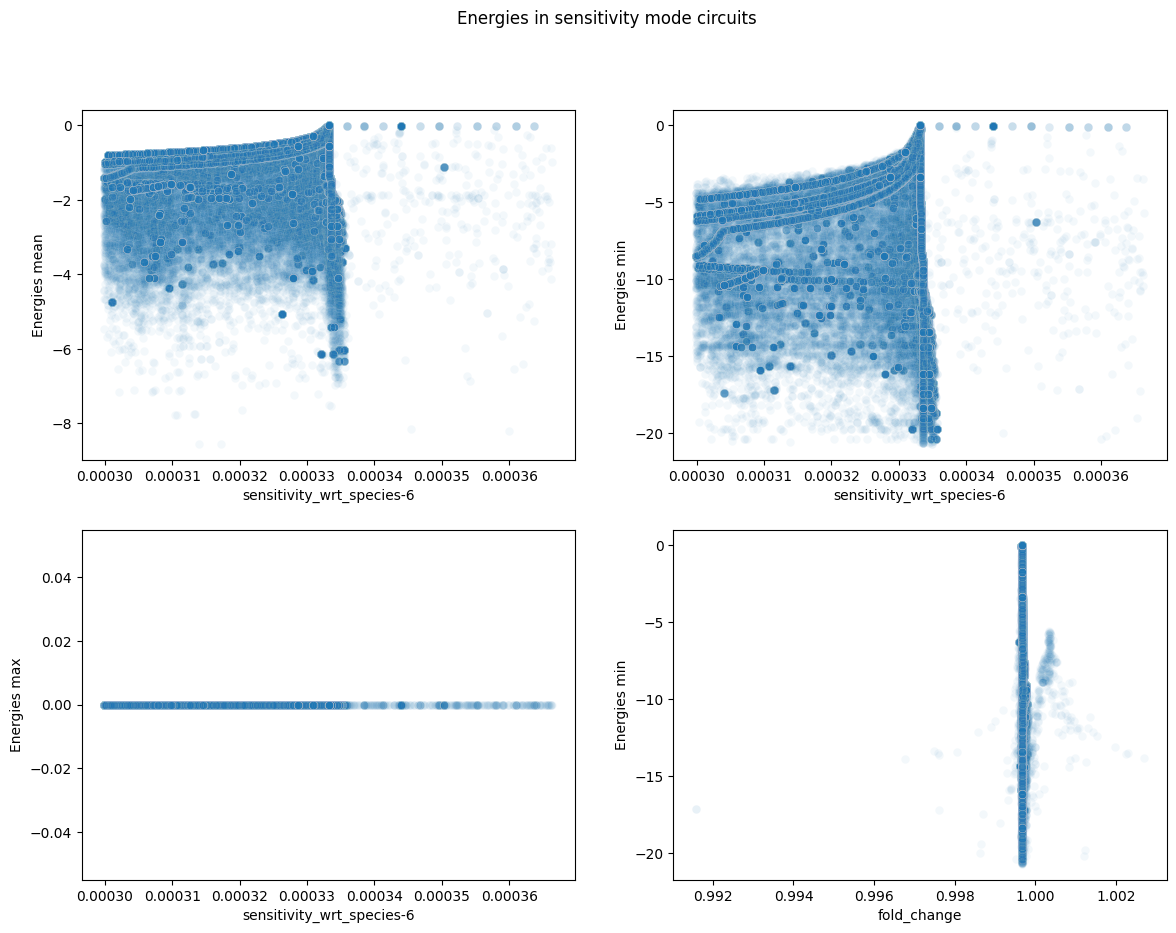

In [137]:
filt = (data['sample_name'] != 'RNA_0') & (data['sensitivity'] > sensitivity_mode_range[0]
                                           ) & (data['sensitivity'] < sensitivity_mode_range[1])
plt.figure(figsize=(2*7, 2*5))

ax = plt.subplot(2,2,1)
sns.scatterplot((data[filt]),
                x='sensitivity', y=data[filt][energy_cols].mean(axis=1),
                alpha=0.05)
plt.ylabel('Energies mean')
ax = plt.subplot(2,2,2)
sns.scatterplot((data[filt]),
                x='sensitivity', y=data[filt][energy_cols].min(axis=1),
                alpha=0.05)
plt.ylabel('Energies min')
ax = plt.subplot(2,2,3)
sns.scatterplot((data[filt]),
                x='sensitivity', y=data[filt][energy_cols].max(axis=1),
                alpha=0.05)
plt.ylabel('Energies max')
ax = plt.subplot(2,2,4)
sns.scatterplot((data[filt]),
                x='fold_change', y=data[filt][energy_cols].min(axis=1),
                alpha=0.05)
plt.ylabel('Energies min')

plt.suptitle('Energies in sensitivity mode circuits')


In [91]:
data[filt][get_true_interaction_cols(
                    data, 'energies', remove_symmetrical=True, num_species=len(data['sample_name'].unique()))]

,energies_0-0,energies_0-1,energies_0-2,energies_1-1,energies_1-2,energies_2-2
5,0.0,-5.83,0.0,-10.06,0.0,0.0
11,0.0,-7.35,0.0,-10.06,0.0,0.0
14,0.0,-4.74,0.0,-10.06,0.0,0.0
16,0.0,0.00,0.0,-10.06,0.0,0.0
17,0.0,0.00,0.0,-10.06,0.0,0.0
...,...,...,...,...,...,...
1628993,0.0,0.00,0.0,0.00,0.0,0.0
1628995,0.0,0.00,0.0,0.00,0.0,0.0
1628996,0.0,0.00,0.0,0.00,0.0,0.0
1628998,0.0,0.00,0.0,0.00,0.0,0.0


### Rates

In [19]:
rates_cols = get_true_interaction_cols(
    data, 'binding_rates_dissociation', remove_symmetrical=True, num_species=len(data['sample_name'].unique()))

Text(0.5, 0.98, 'Rates in sensitivity mode circuits')

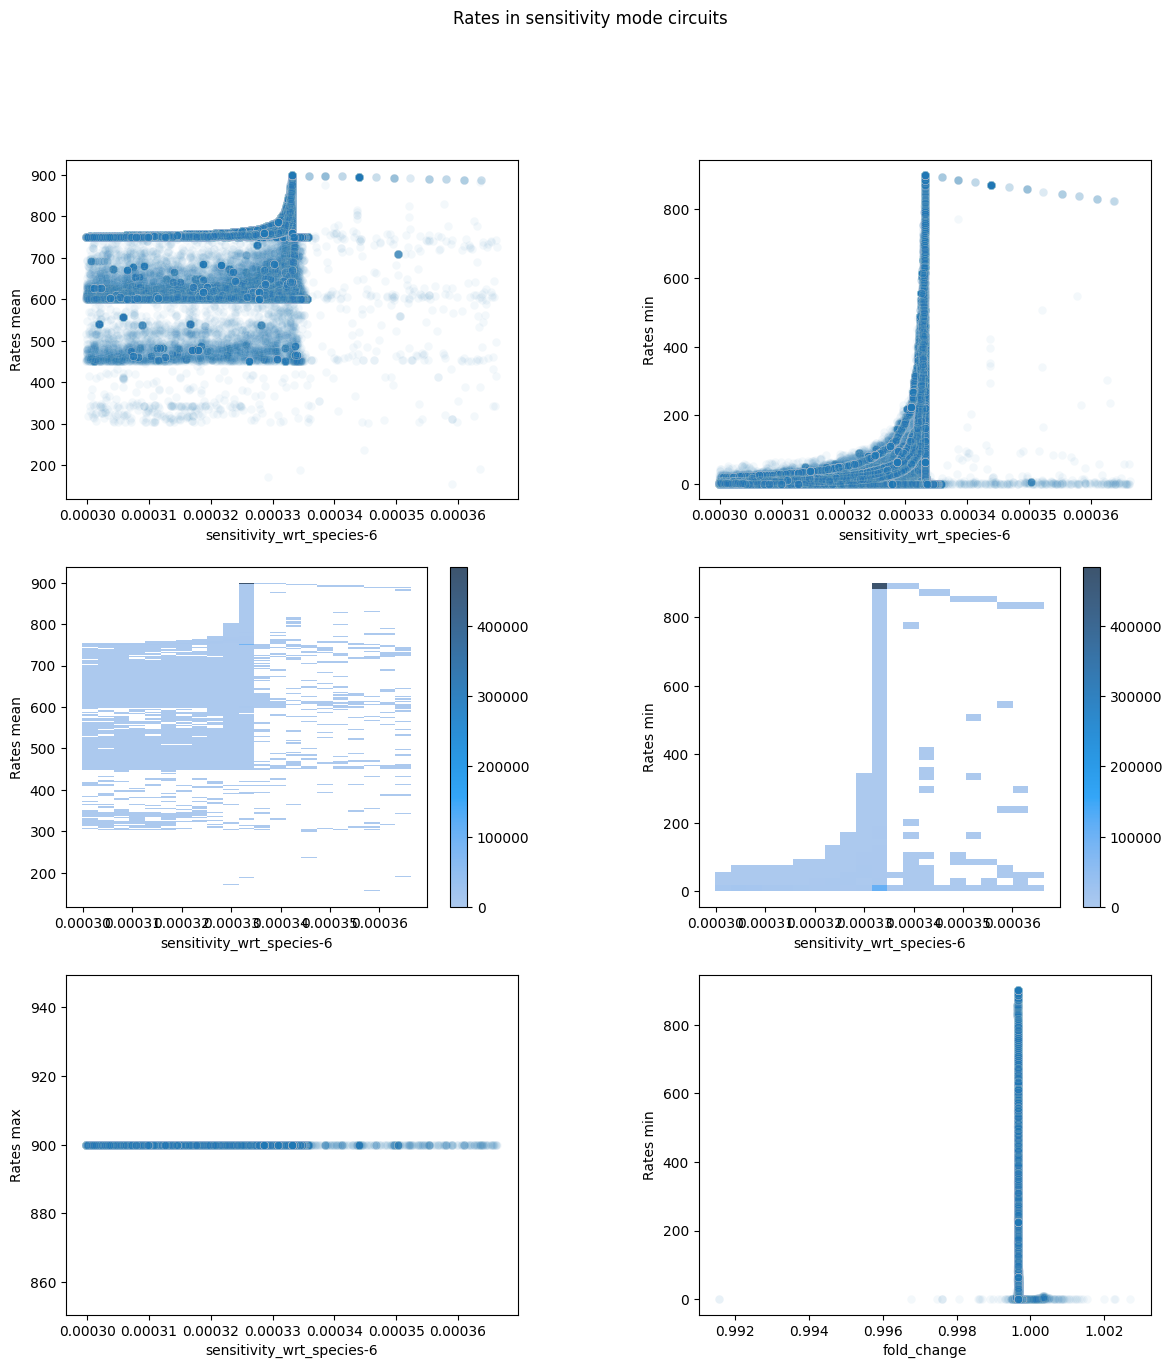

In [37]:
filt = (data['sample_name'] != 'RNA_0') & (data['sensitivity'] > sensitivity_mode_range[0]
                                           ) & (data['sensitivity'] < sensitivity_mode_range[1])

fig = plt.figure(figsize=(2*7, 3*5))
fig.subplots_adjust(wspace=0.4)

ax = plt.subplot(3,2,1)
sns.scatterplot((data[filt]),
                x='sensitivity', y=data[filt][rates_cols].mean(axis=1),
                alpha=0.05)
plt.ylabel('Rates mean')
ax = plt.subplot(3,2,2)
sns.scatterplot((data[filt]),
                x='sensitivity', y=data[filt][rates_cols].min(axis=1),
                alpha=0.05)
plt.ylabel('Rates min')
ax = plt.subplot(3,2,3)
sns.histplot((data[filt]),
                x='sensitivity', y=data[filt][rates_cols].mean(axis=1),
                cbar=True)
plt.ylabel('Rates mean')
ax = plt.subplot(3,2,4)
sns.histplot((data[filt]),
                x='sensitivity', y=data[filt][rates_cols].min(axis=1),
                cbar=True)
plt.ylabel('Rates min')
ax = plt.subplot(3,2,5)
sns.scatterplot((data[filt]),
                x='sensitivity', y=data[filt][rates_cols].max(axis=1),
                alpha=0.05)
plt.ylabel('Rates max')
ax = plt.subplot(3,2,6)
sns.scatterplot((data[filt]),
                x='fold_change', y=data[filt][rates_cols].min(axis=1),
                alpha=0.05)
plt.ylabel('Rates min')

plt.suptitle('Rates in sensitivity mode circuits')


### Rates vs. Energies

In [29]:
eqconstants_cols = get_true_interaction_cols(
    data, 'eqconstants', remove_symmetrical=True, num_species=len(data['sample_name'].unique()))

k_a = per_mol_to_per_molecule(load_json_as_dict('synbio_morpher/utils/common/configs/RNA_circuit/molecular_params.json')['association_binding_rate'])
e = data[energy_cols].melt(value_name='energies')['energies']
eqconstant_to_rates(equilibrium_constant_reparameterisation(e, initial=200), k_a=k_a)

(array([0.00150958, 0.00150958, 0.00150958, ..., 0.00150958, 0.00150958,
        0.00150958]),
 0          899.99949
 1          899.99949
 2          899.99949
 3          899.99949
 4          899.99949
              ...    
 9773995    899.99949
 9773996    899.99949
 9773997    899.99949
 9773998    899.99949
 9773999    899.99949
 Name: energies, Length: 9774000, dtype: float64)

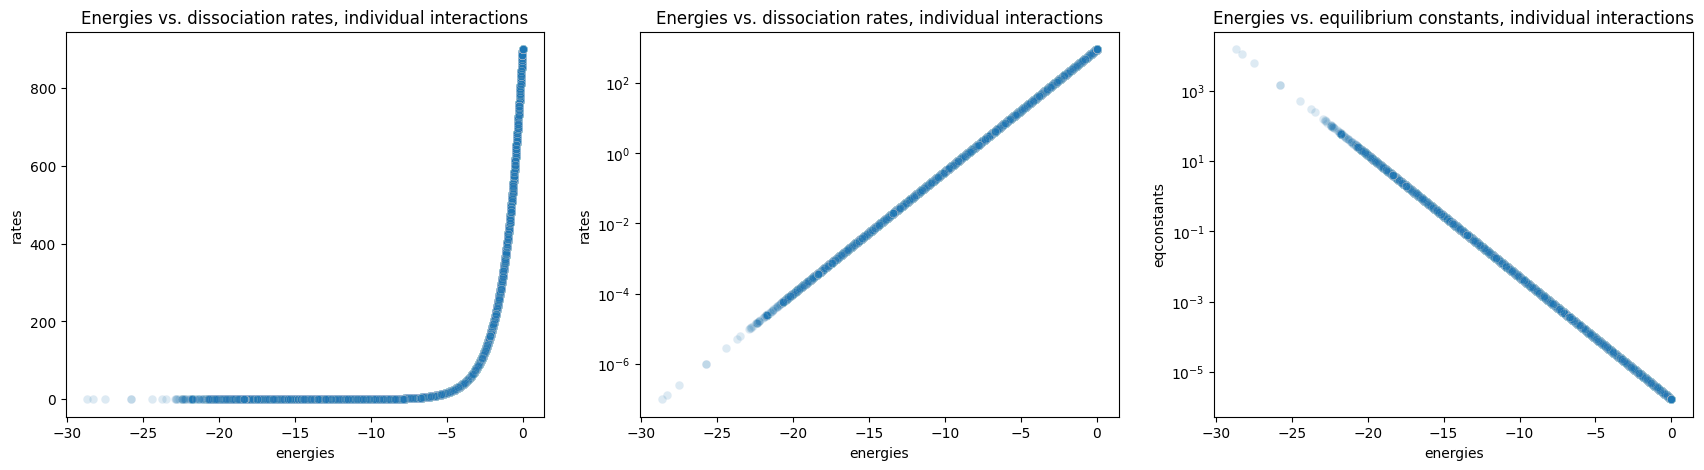

In [32]:
plt.figure(figsize=(3*7, 5))

ax = plt.subplot(1,3,1)
e = data[energy_cols].melt(value_name='energies')['energies']
sns.scatterplot(x=e,
                y=data[rates_cols].melt(value_name='rates')['rates'],
                alpha=0.05)
plt.title('Energies vs. dissociation rates, individual interactions')

ax = plt.subplot(1,3,2)
sns.scatterplot(x=e,
                y=data[rates_cols].melt(value_name='rates')['rates'],
                alpha=0.05)
plt.yscale('log')
plt.title('Energies vs. dissociation rates, individual interactions')

ax = plt.subplot(1,3,3)
sns.scatterplot(x=e,
                y=data[eqconstants_cols].melt(value_name='eqconstants')['eqconstants'],
                alpha=0.05)
plt.title('Energies vs. equilibrium constants, individual interactions')
plt.yscale('log')



Text(0, 0.5, 'Mean rates')

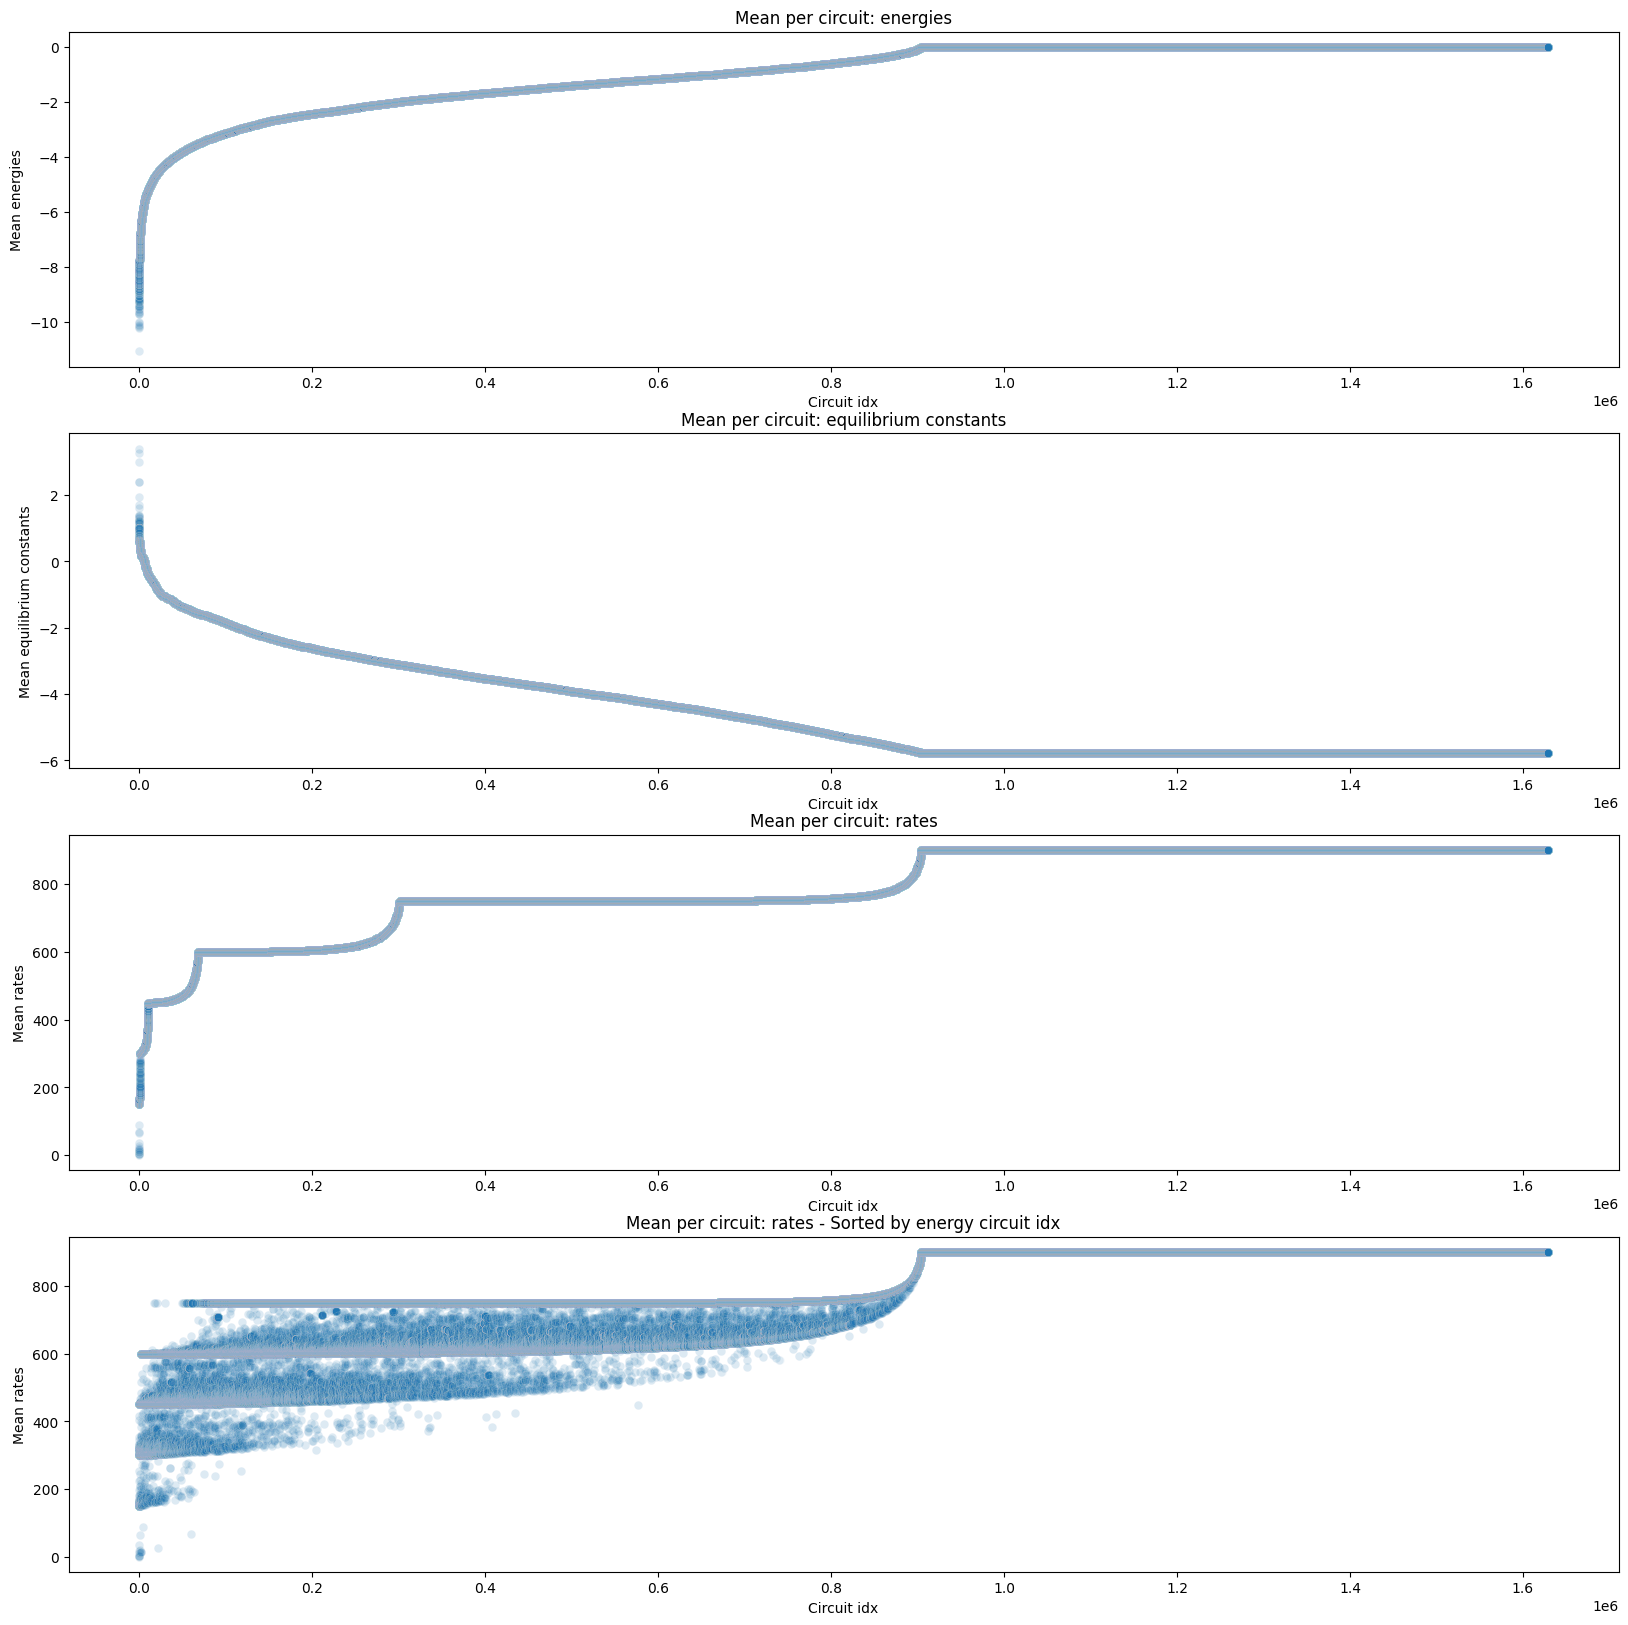

In [39]:
fig = plt.figure(figsize=(20,4*5))
ax = plt.subplot(4,1,1)
sns.scatterplot(data[energy_cols].mean(axis=1).sort_values().reset_index(drop=True),
                alpha=0.05)
plt.title('Mean per circuit: energies')
plt.xlabel('Circuit idx')
plt.ylabel('Mean energies')

ax = plt.subplot(4,1,2)
sns.scatterplot(np.log10(data[eqconstants_cols].mean(axis=1).sort_values(ascending=False).reset_index(drop=True)),
                alpha=0.05)
plt.title('Mean per circuit: equilibrium constants')
plt.xlabel('Circuit idx')
plt.ylabel('Mean equilibrium constants')
# plt.ylabel('log')

ax = plt.subplot(4,1,3)
sns.scatterplot(data[rates_cols].mean(axis=1).sort_values().reset_index(drop=True),
                alpha=0.05)
plt.title('Mean per circuit: rates')
plt.xlabel('Circuit idx')
plt.ylabel('Mean rates')

ax = plt.subplot(4,1,4)
sns.scatterplot(data.loc[data[energy_cols].mean(axis=1).sort_values().index].reset_index(drop=True)[rates_cols].mean(axis=1),
                alpha=0.05)
plt.title('Mean per circuit: rates - Sorted by energy circuit idx')
plt.xlabel('Circuit idx')
plt.ylabel('Mean rates')

Text(0.5, 1.0, 'Energy vs rates means: Within sensitivity mode')

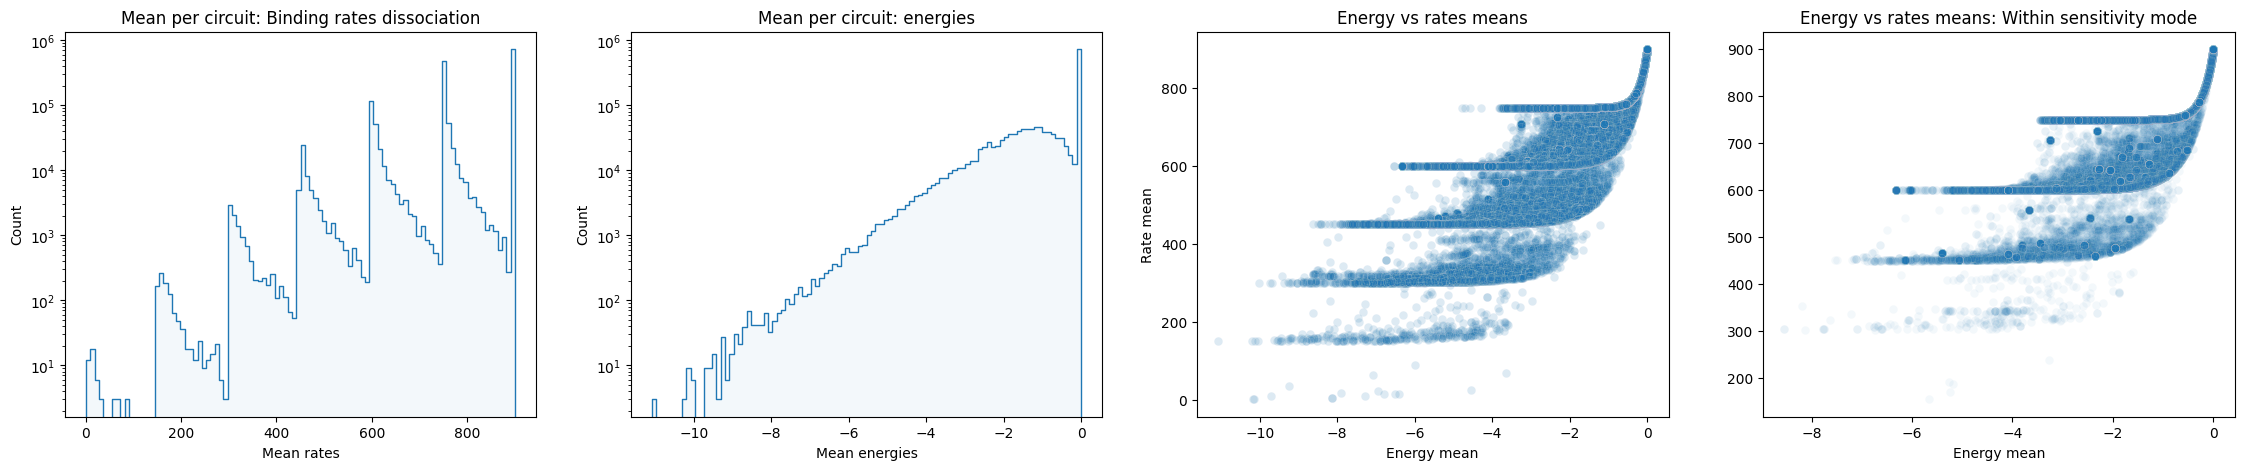

In [38]:

plt.figure(figsize=(4*7, 5))
ax = plt.subplot(1,4,1)
sns.histplot(data[rates_cols].mean(axis=1),
                alpha=0.05, bins=100, element='step', log_scale=[False, True])
plt.title('Mean per circuit: Binding rates dissociation')
plt.xlabel('Mean rates')
ax = plt.subplot(1,4,2)
sns.histplot(data[energy_cols].mean(axis=1),
                alpha=0.05, bins=100, element='step', log_scale=[False, True])
plt.title('Mean per circuit: energies')
plt.xlabel('Mean energies')
ax = plt.subplot(1,4,3)
sns.scatterplot(x=data[energy_cols].mean(axis=1), y=data[rates_cols].mean(axis=1),
                alpha=0.05)
plt.xlabel('Energy mean')
plt.ylabel('Rate mean')
plt.title('Energy vs rates means')
ax = plt.subplot(1,4,4)
sns.scatterplot(x=data[filt][energy_cols].mean(axis=1), y=data[filt][rates_cols].mean(axis=1),
                alpha=0.05)
plt.xlabel('Energy mean')
plt.title('Energy vs rates means: Within sensitivity mode')

# plt.suptitle('Energy vs. rates')

## What should the sensitivity be?

In [123]:
blip_circuits1 = data[data['sensitivity'].isin(sensitivity_mode)]['circuit_id'].unique()
blip_circuits2 = data[(data['sensitivity'] > sensitivity_mode_range[0]) &
                     data['sensitivity'] < sensitivity_mode_range[1]]['circuit_id'].unique()

display_cols = ['max_amount', 'min_amount', 'initial_steady_states', 'steady_states', 'sample_name'] + get_true_interaction_cols(data, 'energies', remove_symmetrical=True)
data[data['circuit_id'].isin(blip_circuits1)][display_cols]


,max_amount,min_amount,initial_steady_states,steady_states,sample_name,energies_0-0,energies_0-1,energies_0-2,energies_1-1,energies_1-2,energies_2-2
183,400.00000,199.73236,199.73236,399.46478,RNA_0,0.0,0.0,0.0,0.0,0.0,0.0
184,199.73236,199.66563,199.73236,199.66563,RNA_1,0.0,0.0,0.0,0.0,0.0,0.0
185,199.73236,199.66563,199.73236,199.66563,RNA_2,0.0,0.0,0.0,0.0,0.0,0.0
198,400.00000,199.73236,199.73236,399.46478,RNA_0,0.0,0.0,0.0,0.0,0.0,0.0
199,199.73236,199.66563,199.73236,199.66563,RNA_1,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1628995,199.73236,199.66563,199.73236,199.66563,RNA_1,0.0,0.0,0.0,0.0,0.0,0.0
1628996,199.73236,199.66563,199.73236,199.66563,RNA_2,0.0,0.0,0.0,0.0,0.0,0.0
1628997,400.00000,199.73236,199.73236,399.46478,RNA_0,0.0,0.0,0.0,0.0,0.0,0.0
1628998,199.73236,199.66563,199.73236,199.66563,RNA_1,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
data[data['circuit_id'].isin(blip_circuits1)][get_true_interaction_cols(data, 'energies', remove_symmetrical=True)].mean(axis=0)

energies_0-0    0.000000
energies_0-1    0.000000
energies_0-2    0.000000
energies_1-1   -0.104003
energies_1-2    0.000000
energies_2-2   -0.105724
dtype: float64

In [96]:
data[data['circuit_id'].isin(blip_circuits2)][get_true_interaction_cols(data, 'energies', remove_symmetrical=True)].mean(axis=0)

energies_0-0   -4.686106
energies_0-1   -1.409039
energies_0-2   -1.324041
energies_1-1   -2.147687
energies_1-2   -0.742960
energies_2-2   -2.106117
dtype: float64

A lot of the circuits that have this weird sensitivity value should actually have a sensitivity of 0 as they have no interactions, but don't because of the fixed association rate. When there is no binding between two RNAs and their binding energy is estimated as zero, the equilibrium constant is 1, meaning that the dissociation rate is 1 / k_a. However, because k_a is non-zero, the k_d will have a non-infinity value, so there is somewhat more interaction than there should be.

Below is an example of how the sensitivity is calculated for such a null circuit and how the imperfect interaction simulation then .
The way to correct for this would be to set the sensitivity of all null circuits to zero for RNAs that are not the signalling RNA. 

In [121]:
min_sens = data[data['sample_name'] != 'RNA_0']['sensitivity'].min()

In [124]:
data[data['sensitivity'] == min_sens][display_cols]

,max_amount,min_amount,initial_steady_states,steady_states,sample_name,energies_0-0,energies_0-1,energies_0-2,energies_1-1,energies_1-2,energies_2-2
745420,199.80257,199.70071,199.80257,199.7919,RNA_1,-19.4,0.0,-19.85,0.0,0.0,0.0


In [99]:

# data[data['circuit_id'].isin(blip_circuits[0])][['max_amount', 'min_amount', 'initial_steady_states', 'steady_states', 'sample_name']]
peaks = compute_peaks(*data[data['circuit_id'].isin([blip_circuits1[0]])][['initial_steady_states', 'steady_states', 'max_amount', 'min_amount']].to_numpy().T)
starting_states=data[data['circuit_id'].isin([blip_circuits1[0]])]['initial_steady_states'].to_numpy()
compute_sensitivity(signal_idx=0, starting_states=starting_states, peaks=peaks)

Array([1.0000000e+00, 3.3318755e-04, 3.3318755e-04], dtype=float32)

Text(0.5, 0, 'Ratio of steady state to initial state')

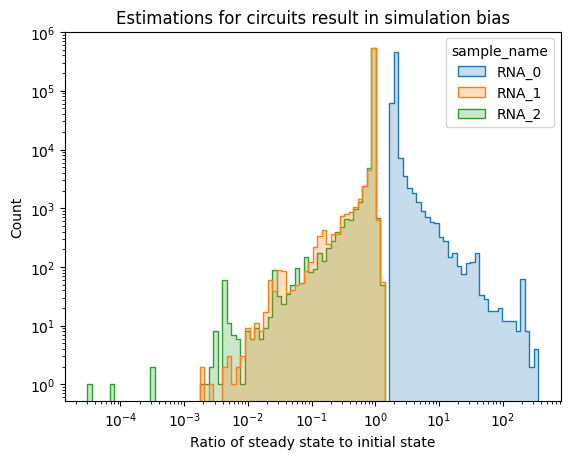

In [100]:
sns.histplot(data, x = 'fold_change', hue=data['sample_name'], bins=100, log_scale=[True, True], element='step')
plt.title('Estimations for circuits result in simulation bias')
plt.xlabel('Ratio of steady state to initial state')

Text(0.5, 1.0, 'Sensitivity when fold change > 1 (no RNA_0)')

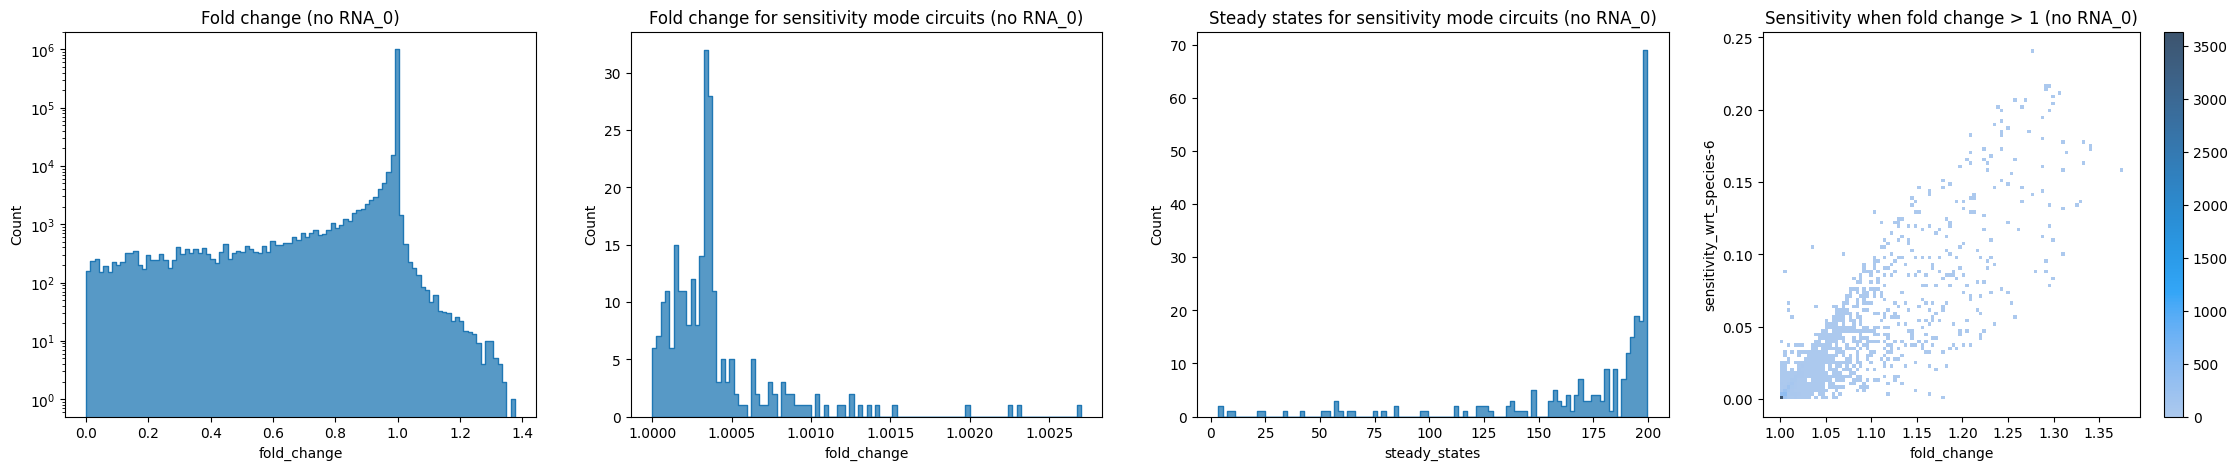

In [116]:
filt = (data['sample_name'] != 'RNA_0') & (
        data[filt]['sensitivity'] > sensitivity_mode_range[0]) & (data[filt]['sensitivity'] < sensitivity_mode_range[-1])
fig = plt.figure(figsize=(4*7, 5))
ax = plt.subplot(1,4,1)
sns.histplot(data[(data['sample_name'] != 'RNA_0')], x='fold_change',
             element='step', bins=100, log_scale=[False, True])
plt.title('Fold change (no RNA_0)')

ax = plt.subplot(1,4,2)
sns.histplot(data[filt], x='fold_change',
             element='step', bins=100)
plt.title('Fold change for sensitivity mode circuits (no RNA_0)')

ax = plt.subplot(1,4,3)
sns.histplot(data[filt], x='steady_states',
             element='step', bins=100)
plt.title('Steady states for sensitivity mode circuits (no RNA_0)')

ax = plt.subplot(1,4,4)
sns.histplot(data[(data['sample_name'] != 'RNA_0') & (data['fold_change'] > 1)], 
             x='fold_change', y='sensitivity',
             element='step', bins=100, cbar=True)
plt.title('Sensitivity when fold change > 1 (no RNA_0)')
# [get_true_interaction_cols(data, 'energies', remove_symmetrical=True)]